## Sensitive analysis
Teraz pod lupę weźmiemy zagadnienie oszacowania, przeanalizowania wrażliwości danej sieci neuronowej na pewne parametry, m.in dane wejściowe, wagi w danych warstwach. Podana analiza pozwala na głębsze zrozumienie modelu, jego funkcjonowania pod względem obróbki danych oraz pracy na nich.  Dlatego w tej pracy domowej, przechodząc przez zbiór danych MNIST, krok po kroku, dokonam testów i wykonam *Sensitive analysis*.  
Również w pracy domowej będę wykorzystywał wiedzę z danego artykułu : https://arxiv.org/abs/1901.07152  
Zawiera on dużo wskazówek oraz jest bazą do wyciągania wniosków przed przystąpieniem do wykonywania pracy.   
Link do zbioru danych MNIST :  http://yann.lecun.com/exdb/mnist/  
Do testów wykorzystałem sprawdzoną i wysoce funkcjonującą siec neuronową na zbiorze MNIST, utworzoną przez autorów powyższego artykułu : https://github.com/shu-hai/SA_DNN/blob/master/aaaipapercodes/DenseNet121.py, jednakże dokonałem jej transkrypcji na  najnowszą wersję kerasa i tensorflowa, gdyż udostępniony przez autorów kod był przestarzały pod tym względem i nie "kooperował" z użytkownikiem (było to po prostu o wiele łatwiejsze wyjście, oczywiście mógłbym operować na tamtejszym modelu 1:1, jednakże byłoby to dośc uporczywe).  
Korzystając z sieci neuronowej utworzonej przez autorów artykułu naukowego będę w stanie jak najbardziej zbliżyć się do uzyskanych przezeń wyników, przy założeniu, iż dostosuję się do wykonanych przezeń korków. 

## Niepeweności pomiarowe w sieciach neuronowych
Zjawisko niepeności polega na, jak wskazuje nazwa, na pewnym odchyleniu naszych danych wejściowych, bądź odchylenie wag w naszej sieci neuronowej. Odchylenia mogą pojawić się w sytuacjach pracy na lekko odchylonych danych względem pierwotnch, lub operowania na modelu wyuczonym na lekko zmodyfikowanych danych, obarczonych pewnym błędem względem oryginału.  
Poradzić sobie możemy z takimi problemami za pomocą narzędzi statystycznych oraz niewielkich poprawek na modelu. Zazwyczaj takie odchylenia mają swoje sposoby na poprawę, gdyż zazwyczaj (zazwyczaj!), błędy takie są modelowane za pomocą funkcji liniowych, bądź kwadratowych, które są dość proste w implementacji. 

### Zaimportujmy potrzebne biblioteki

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import datasets
from PIL import Image

Poniżej dokonuję definicji potrzebnych elementów wykorzystywanych przy sieci neuronowej oraz ją samą. Kod pochodzi ze wcześniej podanego odniesienia. 

Tutaj przygotowuję zbiór danych.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
x_test = x_test /255
x_train = x_train /255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

Funkcje pomocnicze

In [28]:
def plot_model(model,x_set,y_set,epochs = 5):
    history = model.fit(x_set,y_set,epochs = 5)
    
    fig, axs = plt.subplots(1,2)
    plot(history.history['accuracy'])
    axs[0,0].set_title('Model Accuracy')
    axs[0,0].ylabel('accuracy')
    axs[0,0].xlabel('epoch')
    
    plot(history.history['loss'])
    axs[0,1].set_title('Model Loss')
    axs[0,1].ylabel('loss')
    axs[0,1].xlabel('epoch')

Przygotujmy naszą sieć neuronową.

In [3]:
model = keras.Sequential(
[
    keras.Input(shape = (28,28,1)),
    layers.Conv2D(64,kernel_size = (2,2),padding="same",strides=(1,1),activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size = (3,3),padding="same",strides=(1,1),activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(10,activation = 'softmax'),
]
)

Na początku sprawdźmy poprawność naszej sieci neuronowej na niezmodyfikowanym zbiorze danych.

In [47]:
x_test.shape

(10000, 28, 28)

In [65]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [66]:
model.fit(x_train,y_train,epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 67s 35ms/step - loss: 0.2798 - accuracy: 0.9126
Epoch 2/5
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0470 - accuracy: 0.9857
Epoch 3/5
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0284 - accuracy: 0.9906
Epoch 4/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0191 - accuracy: 0.9935
Epoch 5/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0144 - accuracy: 0.9953


313/313 [==============================] - 11s 35ms/step - loss: 0.0356 - accuracy: 0.9876


AttributeError: 'AxesSubplot' object has no attribute 'ylabel'

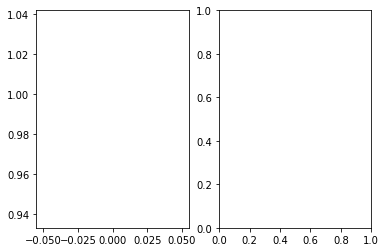

In [26]:
plot_model(model,x_test,y_test)

In [29]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0280 - accuracy: 0.9916


[0.027962487190961838, 0.991599977016449]

Jak widzimy po wynikach, nasza sieć neuronowa działa praktycznie idealnie na oryginalnej tabelce danych, ale czas to zmienić i dokonać trochę eksperymentów.

## Perturbacja danych wejściowych
Na początek weźmy pod uwagę zmiany w naszej sieci neuronowej gdy dokonamy modyfikacji naszych danych wejściowych treningowych oraz nań wytrenowaniu naszego modelu.  
Zacznijmy od zniekształcenia naszego zbioru treningowego poprzez zastowowanie operacji podobnej do augmentacji danych, z tym wyjątkiem, iż tym razem pozbędziemy się wszystkich oryginalnych danych... Być może jak na początek jest to zbyt brutalna operacja, lecz przekonamy się!

In [86]:
## Generator nowych danych
gen = ImageDataGenerator(
rotation_range = 45,
width_shift_range = 0.2,
height_shift_range = 0.2,
shear_range = 0.2,
zoom_range =0.2,
fill_mode = 'constant',
cval = 25
)

In [136]:
gen.fit(x_test)
## By zresetować wagi należy użyć clone_model, w przeciwnym razie zachowalibyśmy je !!!
model_2 = tf.keras.models.clone_model(model)

In [138]:
model_2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_2.fit(gen.flow(x_train, y_train, batch_size = 128), epochs = 5)

Epoch 1/5
469/469 [==============================] - 83s 175ms/step - loss: 2.3304 - accuracy: 0.1392
Epoch 2/5
469/469 [==============================] - 83s 178ms/step - loss: 1.4692 - accuracy: 0.4899
Epoch 3/5
469/469 [==============================] - 86s 184ms/step - loss: 0.9803 - accuracy: 0.6753
Epoch 4/5
469/469 [==============================] - 83s 176ms/step - loss: 0.7458 - accuracy: 0.7576
Epoch 5/5
469/469 [==============================] - 86s 183ms/step - loss: 0.6188 - accuracy: 0.8030


In [139]:
model_2.evaluate(x_test,y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.4997 - accuracy: 0.8295


[0.49965396523475647, 0.8295000195503235]

Wytrenowaliśmy nasz model na zmienionych danych i dokonaliśmy testu na danych oryninalnych i efekt był dość porządny, spadek o około 18 punktów procentowych, czyli nasz model wydaje się dość odporny na takie "ataki", lecz sprawdźmy jeszcze dwa pomniejsze przypadki perturbacji danych wejściowych.

In [90]:
gen2 = ImageDataGenerator(
rotation_range = 2,
width_shift_range = 0.05,
height_shift_range = 0.05,
shear_range = 0.05,
zoom_range =0.05,
fill_mode = 'constant',
)

In [140]:
gen2.fit(x_test)
model_3 = tf.keras.models.clone_model(model)

In [141]:
model_3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_3.fit(gen2.flow(x_train, y_train, batch_size = 16), epochs = 5)

Epoch 1/5
3750/3750 [==============================] - 99s 26ms/step - loss: 0.3308 - accuracy: 0.8922
Epoch 2/5
3750/3750 [==============================] - 93s 25ms/step - loss: 0.0648 - accuracy: 0.9798
Epoch 3/5
3750/3750 [==============================] - 87s 23ms/step - loss: 0.0490 - accuracy: 0.9841
Epoch 4/5
3750/3750 [==============================] - 85s 23ms/step - loss: 0.0413 - accuracy: 0.9870
Epoch 5/5
3750/3750 [==============================] - 85s 23ms/step - loss: 0.0338 - accuracy: 0.9892


In [142]:
model_3.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0319 - accuracy: 0.9896


[0.03193701058626175, 0.9896000027656555]

Jak widać nasz model pozostał praktycznie nietknięty, jednakże poniżej zaprezentuję graficzne przedstawienie "zmiany" danych względem oryginału.

In [143]:
gen2.flow(x_train)

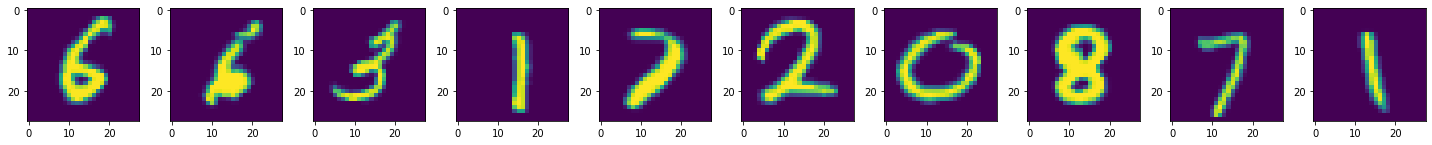

In [144]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [next(gen2.flow(x_train))[i] for i in range(10)]
plotImages(augmented_images)

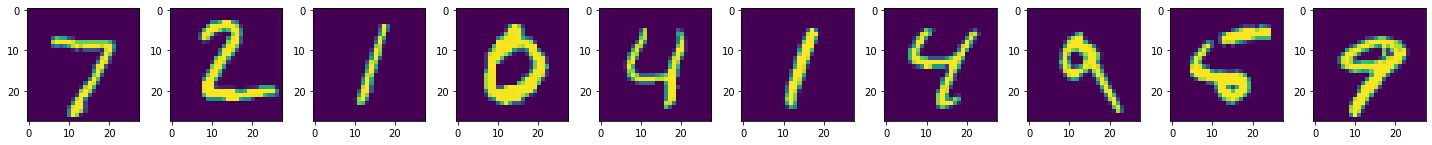

In [99]:
##Dane oryginalne
plotImages([x_test[i] for i in range(10)])

Jak widać dane nie są zbytnio różne od danych wejściowych w zbiorze MNIST, a jednak taka niewielka zmiana spowodowała niefunkcjonalność modelu.

Dobrze, wypróbujmy teraz najmniejszą możliwą zmianę, tudzież zmianę jednego pikselu na losową wartość dla każdej grafiki i na ów danych przetestujmy nasz model. Dlaczego, skoro i tak nasz model dobrze sobie radzi?  Sprawdźmy w jakim stopniu zmiana jednego piksela może wpłynąć na dane.
Najpierw będziemy potrzebowali funkcji pomocniczej zmieniającej 1 piskel w danych.

In [98]:
import random as rn

def pixel(array):
    rn.seed(1337)
    copy = array.copy()
    for x in copy:
        x_r = rn.randint(0,27)
        y_r = rn.randint(0,27)
        val = rn.uniform(0,1)
        x[x_r][y_r][0] = val
    return copy

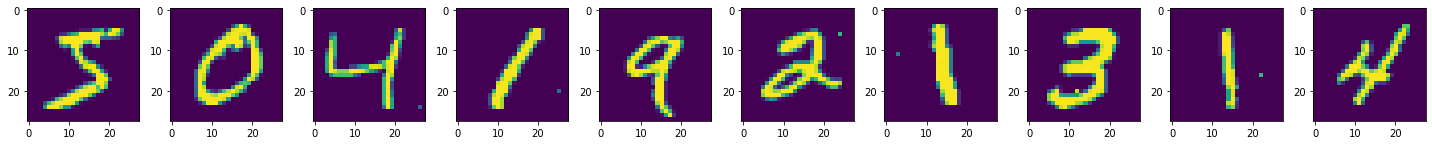

In [114]:
plotImages([pixel(x_train)[i] for i in range(10)])

Jak widać miejscowo można zaobserwować klarownie pojedyńcze zmienione piksele. A teraz sprawdźmy jak poradzi sobie nasz model na tej minimalnej perturbacji.

In [145]:
model_4 = tf.keras.models.clone_model(model)
model_4.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_4.fit(pixel(x_train),y_train,epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 89s 47ms/step - loss: 0.3242 - accuracy: 0.8976
Epoch 2/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.0491 - accuracy: 0.9843
Epoch 3/5
1875/1875 [==============================] - 92s 49ms/step - loss: 0.0322 - accuracy: 0.9900
Epoch 4/5
1875/1875 [==============================] - 89s 47ms/step - loss: 0.0213 - accuracy: 0.9937
Epoch 5/5
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0155 - accuracy: 0.9952


In [146]:
model_4.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0442 - accuracy: 0.9871


[0.04421951621770859, 0.9871000051498413]

Zmiana jednego piksela praktycznie nie wpływa na wyniki, choć wynik na zbiorze testowym uległ pogorszeniu o niecały punkt procentowy.

## Perturbacja wag w określonej warstwie
Na początku ustawmy ręcznie wagi dla określonej warstwy jako stałe arbitralne wartości i sprawdźmy reakcje sieci neuronowej. 

In [67]:
model_5 = tf.keras.models.clone_model(model)

In [135]:
## Wagi w naszej warstwie zostały zainicjalizowane losowo
model_5.layers[0].get_weights()

[array([[[[-1.21045232e-01, -5.36748469e-02,  1.29365474e-01,
           -1.40081584e-01, -1.33318409e-01, -1.14914879e-01,
            8.26455653e-02,  6.58971369e-02, -1.38035119e-02,
            1.41302943e-01, -3.43335792e-02,  1.49601430e-01,
           -1.06349736e-01, -8.01233202e-02,  4.46631312e-02,
            1.14324927e-01,  4.58939373e-02,  1.15494847e-01,
            3.81925404e-02, -1.34445921e-01,  1.32089347e-01,
            6.89441860e-02, -1.15234286e-01, -4.10872176e-02,
            1.42128170e-02, -2.59790123e-02, -5.51417470e-03,
           -5.88330999e-02, -7.65708759e-02,  9.02570337e-02,
           -8.76188949e-02,  1.17958426e-01,  3.31192166e-02,
            5.61189651e-02, -1.31852254e-01, -1.18892811e-01,
            1.02808088e-01,  1.22224301e-01,  1.16515547e-01,
           -1.31595075e-01,  1.28191739e-01, -3.83253098e-02,
           -1.20114930e-01,  2.50434130e-02,  1.21600509e-01,
            9.08361673e-02, -9.09627900e-02, -6.43680692e-02,
        

In [68]:
weights_start_CNN = model_5.layers[0].get_weights()
weights_start_pooling = model_5.layers[3].get_weights()
weights_start_dense = model_5.layers[5].get_weights()

In [150]:
model_5.layers

Przećwiczmy nasz model na oryginalnym zbiorze treningowym, a następnie podmieńmy wagi wyćwiczone z wagami ze stanu początkowego i sprawdźmy nasz model na zbiorze testowym!

In [69]:
model_5.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_5.fit(x_train,y_train,epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.3138 - accuracy: 0.9014
Epoch 2/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0467 - accuracy: 0.9851
Epoch 3/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0321 - accuracy: 0.9898
Epoch 4/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0236 - accuracy: 0.9925
Epoch 5/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0173 - accuracy: 0.9945


In [70]:
#Podmiana, ale najpierw zachowajmy model dla dalszych testów (z wagami!!!)
model_5_prim = model_5
model_5_bis = model_5
model_5_ter = model_5
model_5_quadr = model_5

In [158]:
#Podmianka
model_5.layers[0].set_weights(weights_start_CNN)

In [159]:
model_5.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 1.6734 - accuracy: 0.4731


[1.673365831375122, 0.4731000065803528]

Jak widzimy w powyższym przykładzie, podmiana wag w warstwie CNN zaskutkowało spadkiem o 50 punktów procentowych accuracy naszego modelu, tudzież początkowa warstwa CNN ma duże znaczenie w ustalaniu następnych wag i końcowego wyniku!

Teraz sprawdźmy osobno podmienienie dla innych warstw, a na końcu dla wszystkich jednocześnie (choć zakładam, iż skutek będzie katastrofalny)

In [164]:
model_5_prim.layers[3].set_weights(weights_start_pooling)

In [165]:
model_5_prim.evaluate(x_test,y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.6734 - accuracy: 0.4731


[1.673365831375122, 0.4731000065803528]

Skutek podobny co dla warstwy konwolucji.

In [166]:
model_5_bis.layers[5].set_weights(weights_start_dense)

In [167]:
model_5_bis.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 2.3132 - accuracy: 0.1376


[2.3131885528564453, 0.13760000467300415]

Dla zresetowanych wag w warstwie Dense, zmiana była najbardziej dotkliwa z pośród wszystkich poprzednich.  
Jednakże co się stanie dla zresetowania wszystkich trzech?

In [175]:
model_5_ter.layers[0].set_weights(weights_start_CNN)
model_5_ter.layers[3].set_weights(weights_start_pooling)
model_5_ter.layers[5].set_weights(weights_start_dense)

In [173]:
model_5_ter.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 2.3132 - accuracy: 0.1376


[2.3131885528564453, 0.13760000467300415]

### Procentowe odchylenie dla wag
Dokonaliśmy już "hard resetu" dla wag, jednakże co jeżeli zastosujemy (jak narazie) stałe odchylenie dla wag w postaci odchylenia w skali 10% wartości wag w dół lub górę, zobaczmy jak systematyczne odchylenie wpływa na dane? Sprawdźmy to!  
Dopowiedzieć muszę jeszcze, iż przy implementacji tego "problemu" również posługiwałem się informacjami zawartymi w tym artykule : https://www.intechopen.com/books/artificial-neural-networks-models-and-applications/advanced-methods-in-neural-networks-based-sensitivity-analysis-with-their-applications-in-civil-engi

Zdefiniujmy funkcje pomocniczą do modyfikacji naszych wag.

In [191]:
def weights_mod(wages_list,change_val,random = False):
    new_wages = wages_list.copy()
    if random == True:
        rn.seed(7331)
        try:
            for i in len(new_wages[0]):
                a = rn.uniform(-change_val,change_val)
                new_wages[0][i] = new_wages[0][i] * (1+a)
        except Exception:
            pass
        try:
            for j in len(new_wages[1]):
                a = rn.uniform(-change_val,change_val)
                new_wages[0][j] = new_wages[0][j] * (1+a)
        except Exception:
            pass
        return new_wages
    else:
        try:
            new_wages[0] = new_wages[0] * (1+change_val)
            new_wages[1] = new_wages[1] * (1+change_val)
        except Exception:
            pass
    return new_wages

Na początku zajmijmy się wagami warstwy CNN, gdyż jak wiemy z poprzedniego punktu były najbardziej znaczące.

In [84]:
CNN_weights_mod = weights_mod(model_5.layers[0].get_weights(),0.1)

In [87]:
model_5_quadr.layers[0].set_weights(CNN_weights_mod)
model_5_quadr.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0403 - accuracy: 0.9882


[0.0403343066573143, 0.9882000088691711]

Jak widzimy 10% zmiana wag pogorszyła nieznacznie wyniki naszej ewaluacji, zobaczmy co się stanie dla bardziej drastycznej zmiany, tudzież 50% wzrostu.

In [94]:
CNN_weights_mod = weights_mod(weights_start_CNN,0.5)
model_5_quadr.layers[0].set_weights(CNN_weights_mod)
model_5_quadr.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.1005 - accuracy: 0.9696


[0.10046955943107605, 0.9696000218391418]

Ponownie nastąpiła zmiana, lecz ogólne wyniki są nadal dość wysokie, dobrze teraz ostatecznie sprawdźmy zmianę dla 10000% zmienionych wag, tym razem w przeciwnym kierunku względem osi OX.

In [95]:
CNN_weights_mod = weights_mod(weights_start_CNN,-1001)
model_5_quadr.layers[0].set_weights(CNN_weights_mod)
model_5_quadr.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 1406.9655 - accuracy: 0.2641: 0s - loss: 1397.3093 - accurac


[1406.9654541015625, 0.26409998536109924]

Trafiony, zatopiony, dopiero dla tak drastycznej zmiany nasz model wreszcie uległ, chociaż dla identycznego dodatniego ochylenia nadal radził sobie bardzo dobrze, jak pokazano poniżej, jednakże w ogólności okazał się dość odporny na ustandaryzowany błąd, co będzie gdy błąd ten nie będzie ustandaryzowany a losowy, przykonajmy się!

In [96]:
CNN_weights_mod = weights_mod(weights_start_CNN,999)
model_5_quadr.layers[0].set_weights(CNN_weights_mod)
model_5_quadr.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 63.8142 - accuracy: 0.9651


[63.81422424316406, 0.9650999903678894]

### Losowa zmiana wag
Dokonajmy identycznego "ataku", tym razem każda wartość wag we warstwie ulegnie innej zmianie z podanego zakresu, znowu przyjrzymy się wyłącznie warstwie CNN w celach zwięzłości poniższej pracy domowej oraz z faktu, iż ów warstwa najwięcej "znaczy" w naszym modelu.

In [164]:
model_6 = model
CNN_weights_mod = weights_mod(model_5.layers[0].get_weights(),0.1,random = True)

In [165]:
model_6.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [166]:
model_6.layers[0].set_weights(CNN_weights_mod)
model_6.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 1254.5720 - accuracy: 0.3628


[1296.724853515625, 0.35260000824928284]

Tak jak wewnętrznie przypuszczałem, losowe zmiany mają katastrofalne skutki jeżeli chodzi o accuracy w przeciwieństwie do uporządkowanych, choć nasz model i tak trafiał lepiej niż wskazywałoby to prawdopodobieństwo. No dobrze, a co będzie dla drastyczniejszej zmiany niż tylko 10%, np. 200%?

In [167]:
CNN_weights_mod = weights_mod(model_5.layers[0].get_weights(),1,random = True)
model_6.layers[0].set_weights(CNN_weights_mod)
model_6.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 1296.7249 - accuracy: 0.3526


[1296.724853515625, 0.35260000824928284]

Nie było już znacznych zmian w funkcjonowaniu modelu, już poprzednio został zneutralizowany toteż ciężko by było jeszcze bardziej dogłębnie pogorszyć ten wynik.

## Perturbacja we wszystkich warstwach modelu
Dotarliśmy do ostatniego punktu naszej analizy, mianowicie zmieńmy globalnie wszystkie wagi w pewnym stopniu, jak domyślamy się losowa zmiana wag prawdopowodnie całkowicie zneutralizuje model, dlatego zacznijmy od zmian wag w sposób standardowy, z pewnym przesunięciem.

In [168]:
model_7 = model

In [169]:
for i in range(len(model_7.layers)):
    weights_modified = weights_mod(model_5.layers[i].get_weights(),0.1)
    model_7.layers[i].set_weights(weights_modified)

In [170]:
model_7.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_7.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 93.7770 - accuracy: 0.9631


[93.43367767333984, 0.9650999903678894]

Teraz może bardziej drastyczna zmiana, lecz ciągle przesunięta w pewnym kierunku?

In [171]:
model_8 = model
for i in range(len(model_8.layers)):
    weights_modified = weights_mod(model_5.layers[i].get_weights(),10)
    model_8.layers[i].set_weights(weights_modified)
model_8.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_8.evaluate(x_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 938018.4112 - accuracy: 0.9631


[934629.8125, 0.9652000069618225]

Jak widać skalowanie przez pewną liczbę wag praktycznie nie zmienia wyniku naszego modelu, lecz przypuszczam, iż przeskalowanie przez liczbę o przeciwnym znaku zakłóci nasz wynik, sprawdźmy to.

In [172]:
model_9 = model
for i in range(len(model_9.layers)):
    weights_modified = weights_mod(model_5.layers[i].get_weights(),-11)
    model_9.layers[i].set_weights(weights_modified)
model_9.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model_9.evaluate(x_test,y_test)

313/313 [==============================] - 4s 11ms/step - loss: 391085049.3758 - accuracy: 0.2077


[402218624.0, 0.19059999287128448]

Przypuszczenie było prawidłowe i nasz model został zatopiony, chociaż nadal był lepszy niż całkowite zgadywanie.

Jeżeli chodzi o przypadek losowej inicjalizacji w obrębie całej sieci neuronowej to byłoby to równoznaczne z zresetowaniem wszystkich wag, zatem nie będę analizować takiego przypadku, gdyż wiadomo, iż zneutralizuje całkowicie nasz model.

## Wnioski
Nasza siec okazała się być dość odporna na perturbacje danych wejściowych, czego możnabyło się spodziewać, gdyż zbiór MNIST nie jest dość wymagającym zbiorem pod względem powłok i różnorodności wartości pikseli, zatem nawet dość zmodyfikowane obrazy okazały się być rozróżnialne przez model.  
W przypadku zmiany wag w pewnych warstwach, to najważniejszymi wagami okazały się te z pierwszej warstwy konwolucyjnej. Dokonanie całkowitej losowej zmiany, bądź resetu, w obrębie tej warstwy znacząco obniżało accuracy naszego modelu (o około 80 punktów procentowych). Jednakże stała zmiana dla wszystkich wag, tudzież przeskalowanie ich przez pewną liczbę. Takie zmiany powodowały pewne "przesunięcie" od optimum, lecz modele nadal operowały z dużą accuacy.  
W przypadku zmiany stałej dla wszystkich warstw, błąd okzywał się jeszcze mniejszy, tudzież dokonanie takiego przesunięcia dla wszystkich warstw nie dokonuje zmian dla modelu, chociaż w tym przypadku zależy to także od funkcji optymalizacyjnej.  
Losowa perturbacja dla każdej osobnej wagi w obrębie całej sieci, wiązałoby się z jej resetem, zatem zneutralizowałoby to naszą sieć.